# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, gridspec
import os
import cv2
from PIL import Image

from scipy.interpolate import splrep, splev
from scipy.ndimage import gaussian_filter
from sklearn.linear_model import RANSACRegressor
from sklearn.cluster import DBSCAN
from skimage import feature
from skimage import img_as_float
from skimage.filters import gabor
from skimage.transform import hough_line, hough_line_peaks
from skimage.measure import label, regionprops
from sklearn.decomposition import PCA

import time
import math
from collections import deque

In [2]:
claheFilter = cv2.createCLAHE(clipLimit=40)

# Functions

In [3]:
def compute_angle(line_X, line_Y):
    """
    Compute the angle of a line given its X and Y coordinates.

    Parameters:
    line_X (numpy.ndarray): X-coordinates of the line.
    line_Y (numpy.ndarray): Y-coordinates of the line.

    Returns:
    float: Angle of the line in degrees, normalized to [0, 180].
    """
    print(line_X.shape, line_Y.shape)
    print(line_X[0], line_Y[0])
    dy = line_Y[-1] - line_Y[0]
    dx = line_X[-1][0] - line_X[0][0]
    print(dy, dx)
    angle = math.degrees(math.atan2(dy, dx))
    print(angle)
    return angle if angle >= 0 else angle + 180  # Normalize angle to [0, 180]

In [4]:
def loadAndReturnNormalisedHSV(filepath):
    """
    Input: filepath of rgb image
    Output:
        Image converted to HSV colorspace, then grayscaled and normalised
    """
    img = Image.open(filepath)
    img_arr = np.array(img)
    hsv_image = cv2.cvtColor(img_arr, cv2.COLOR_BGR2HSV)
    grayscale_hsv = np.mean(hsv_image, axis=-1)
    
    # grayscale_hsv = hsv_image[:,:,0]
    # print(grayscale_hsv.shape)
    # print(grayscale_hsv.shape, grayscale_hsv.dtype)
    # grayscale_hsv = claheFilter.apply(grayscale_hsv)
    norm_hsv = (((grayscale_hsv - grayscale_hsv.min()) / (grayscale_hsv.max() - grayscale_hsv.min()))*255).astype(np.uint8)
    # norm_hsv = np.array(norm_hsv)
    # print(norm_hsv.shape, norm_hsv.dtype)
    # print(norm_hsv)
    
    norm_hsv = claheFilter.apply(norm_hsv)
    return norm_hsv

In [5]:
def createPlantMask(filepath):
    cmap = colormaps.get_cmap('jet') # jet plasma inferno viridis
    clahe_norm_hsv = loadAndReturnNormalisedHSV(filepath)
    print(clahe_norm_hsv.shape)
    
    clahe_colored_overlay = cmap(clahe_norm_hsv)[:, :, :3]

    selected_channel = clahe_colored_overlay[:,:,0]

    selected_channel_gray = (selected_channel*255).astype(np.uint8)

    return selected_channel

In [6]:
def bfs(start_i, start_j, closed_mask_small, visited):
    q = deque()
    q.append((start_i, start_j))
    visited[start_i, start_j] = True
    region_pixels = []  # To store all connected pixels

    # Use 4-neighborhood connectivity (you can extend to 8 if needed)
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    
    while q:
        i, j = q.popleft()
        region_pixels.append((i, j))
        for di, dj in neighbors:
            ni, nj = i + di, j + dj
            if (0 <= ni < closed_mask_small.shape[0] and 0 <= nj < closed_mask_small.shape[1]):
                if (not visited[ni, nj]) and (closed_mask_small[ni, nj] == 0.0):
                    visited[ni, nj] = True
                    q.append((ni, nj))
    return region_pixels

In [7]:
def createDirtMask(filepath):
    image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    image_float = img_as_float(image)
    frequency = 0.2  # Adjust based on the texture scale
    theta = np.pi / 4  # Orientation of the filter (in radians)
    
    # Apply the Gabor filter (returns real and imaginary responses)
    real_response, image_response = gabor(image_float, frequency=frequency, theta=theta)
    
    # Compute the magnitude of the response
    magnitude = np.sqrt(real_response**2 + image_response**2)

    # Simple segmentation: threshold the magnitude response
    threshold_value = magnitude.mean()  # Example threshold (could also use Otsu's method, etc.)
    segmented_texture = magnitude > threshold_value

    gabor_mask = (segmented_texture.astype(np.uint8))*255

    selected_kernel_sizes = [17, 9]
    kernel_large = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (selected_kernel_sizes[0], selected_kernel_sizes[0]))
    kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (selected_kernel_sizes[1], selected_kernel_sizes[1]))
    
    closed_mask_large = cv2.morphologyEx(gabor_mask, cv2.MORPH_CLOSE, kernel_large)
    closed_mask_small = cv2.morphologyEx(gabor_mask, cv2.MORPH_CLOSE, kernel_small)
    
    closed_mask_large = np.abs(closed_mask_large) > 0
    closed_mask_small = np.abs(closed_mask_small) > 0

    overlap_mask = np.zeros(closed_mask_large.shape)
    for i in range(overlap_mask.shape[0]):
        for j in range(overlap_mask.shape[1]):
            if(not(closed_mask_large[i][j]) and not(closed_mask_small[i][j])):
                overlap_mask[i][j] = 255

    visited = np.zeros_like(overlap_mask, dtype=bool)

    # This will hold the refined dirt area (True where dirt is found)
    dirt_area_map = np.zeros_like(overlap_mask, dtype=bool)
    
    for i in range(overlap_mask.shape[0]):
        for j in range(overlap_mask.shape[1]):
            if (overlap_mask[i, j]==255.0) and (visited[i, j] == False):
                region = bfs(i, j, closed_mask_small, visited)
                # Optionally, filter out small regions (noise) by size:
                if len(region) >= 50:  # for example, only accept regions with at least 50 pixels
                    for (pi, pj) in region:
                        dirt_area_map[pi, pj] = True

    return dirt_area_map

In [8]:
filepath = "Dataset2/train/DJI_0002_0_5_JPG.rf.70b07b52bde88868cd7020f164a42318.jpg"

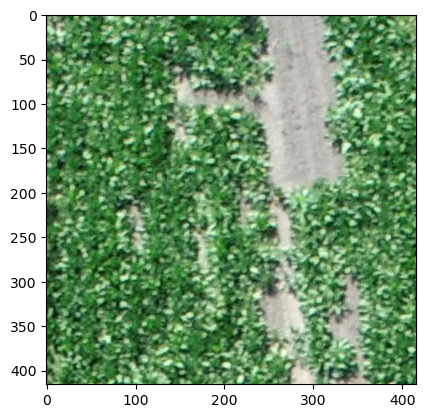

In [13]:
img = cv2.imread("Dataset2/train/DJI_0002_0_5_JPG.rf.70b07b52bde88868cd7020f164a42318.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

# Crop Mask Generation

## Crop Area Identification

(416, 416)


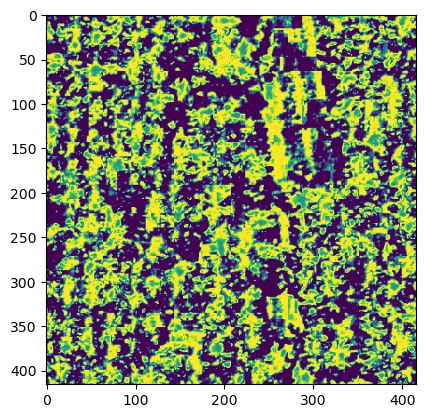

In [14]:
crop_area_mask = createPlantMask(filepath)
plt.imshow(crop_area_mask)

## Dirt Area Identification

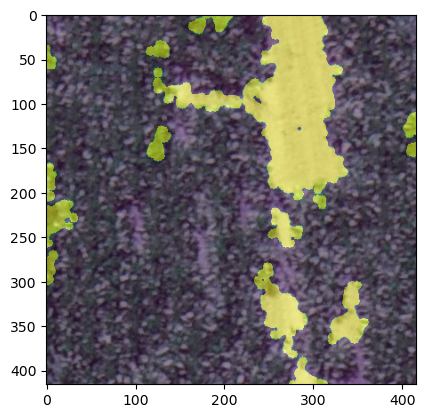

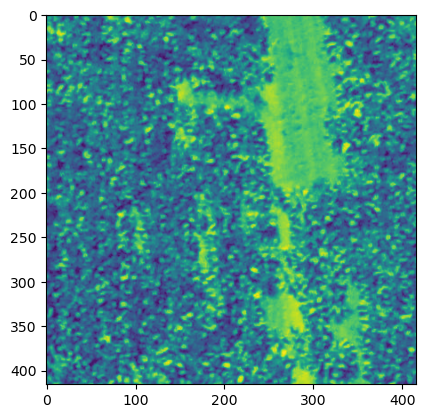

In [15]:
dirt_area_mask = createDirtMask(filepath)
plt.imshow(cv2.imread(filepath))
plt.imshow(dirt_area_mask, alpha=0.5)
plt.show()

plt.imshow(cv2.imread(filepath, cv2.IMREAD_GRAYSCALE))
# plt.imshow(dirt_area_mask, alpha=0.5)
plt.show()

## Blocking dirt areas in crop mask

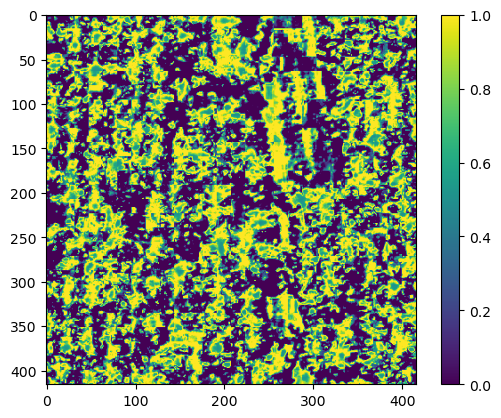

In [16]:
crop_area_without_dirt_mask = crop_area_mask.copy()
plt.imshow(crop_area_without_dirt_mask)
plt.colorbar()

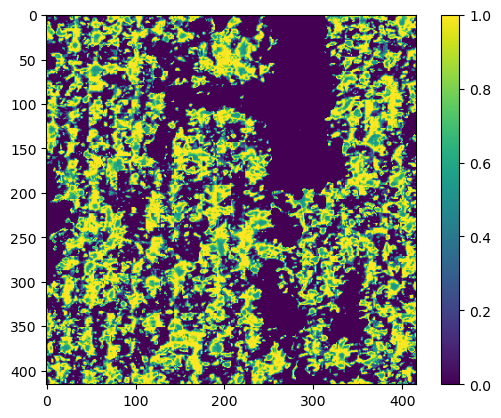

In [17]:
for i in range(crop_area_mask.shape[0]):
    for j in range(crop_area_mask.shape[1]):
        if(dirt_area_mask[i][j]):
            crop_area_without_dirt_mask[i][j] = 0

plt.imshow(crop_area_without_dirt_mask)
plt.colorbar()

### Experiment w closing

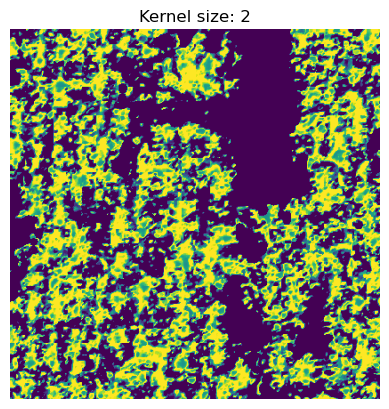

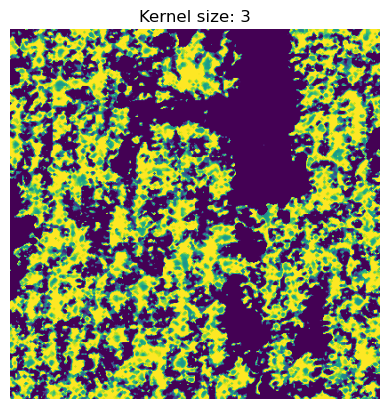

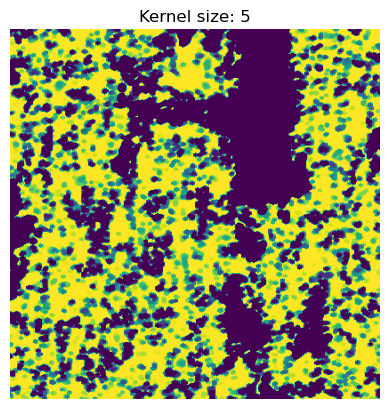

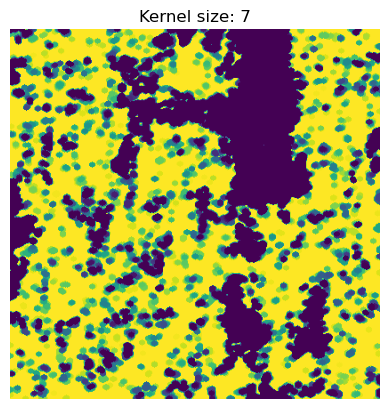

In [18]:
# crop_close_mask = np.zeros_like(crop_area_without_dirt_mask)
# for i in range(crop_close_mask.shape[0]):
#     for j in range(crop_close_mask.shape[1]):
#         crop_close_mask[i][j] = 1-crop_area_without_dirt_mask[i][j]
        
for kernel_size in [2,3,5,7]:
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    closed_mask = cv2.morphologyEx(crop_area_without_dirt_mask, cv2.MORPH_CLOSE, kernel)
    # for i in range(closed_mask.shape[0]):
    #     for j in range(closed_mask.shape[1]):
    #         closed_mask[i][j] = 1 - closed_mask[i][j]
    plt.imshow(closed_mask)
    plt.title(f"Kernel size: {kernel_size}")
    plt.axis('off')
    plt.show()

# Weed Detection using ML

DETECT WEEDS HERE OR SMTH

## Weed annotation

ANNOTATE DETECTED WEEDS HERE

In [ ]:
annotated_image = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
# Loop over each detected bounding box and draw it.
weed_count = 0

for (x, y, w, h) in boxes:
    # Optionally, you could check if the center of the box lies in the crop mask.
    cx, cy = x + w//2, y + h//2
    if crop_area_without_dirt_mask[cy, cx]:
        color = (0, 255, 0)  # Green for boxes in crop areas
        weed_count += 1
    else:
        color = (0, 0, 255)  # Red if outside (should not occur if you already blocked dirt areas)
    cv2.rectangle(annotated_image, (x, y), (x + w, y + h), color, 2)
    cv2.putText(annotated_image, "weed", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.title("Annotated Weeds on Image")
plt.axis('off')
plt.show()

# Weed density estimation

In [ ]:
total_crop_area = np.sum(crop_area_without_dirt_mask)

In [ ]:
weed_density = weed_count / total_crop_area

print("Total crop area (pixels):", total_crop_area)
print("Number of weeds in crop areas:", weed_count)
print("Weed density (weeds per pixel):", weed_density)

## Image subdivision

In [ ]:
# Define grid cell size (in pixels)
cell_size = 100  # adjust based on your image resolution

# Determine the number of cells in each direction
n_rows = height // cell_size
n_cols = width // cell_size

# Create an empty density grid
density_grid = np.zeros((n_rows, n_cols), dtype=float)

## Density estimation

In [ ]:
# Loop over grid cells
for i in range(n_rows):
    for j in range(n_cols):
        # Define cell boundaries
        row_start = i * cell_size
        row_end = row_start + cell_size
        col_start = j * cell_size
        col_end = col_start + cell_size

        # Crop mask for the cell
        cell_crop_mask = crop_mask[row_start:row_end, col_start:col_end]
        cell_area = np.sum(cell_crop_mask)  # crop area in this cell

        # Count weeds in the cell (check if bounding box center lies in this cell and in crop area)
        cell_weed_count = 0
        for (x, y, w, h) in boxes:
            cx, cy = x + w//2, y + h//2
            if row_start <= cy < row_end and col_start <= cx < col_end:
                if crop_mask[cy, cx]:
                    cell_weed_count += 1

        # Compute density (avoid division by zero)
        if cell_area > 0:
            density_grid[i, j] = cell_weed_count / cell_area
        else:
            density_grid[i, j] = 0

# Visualize the density grid
plt.figure(figsize=(8, 6))
plt.imshow(density_grid, cmap='viridis', interpolation='nearest')
plt.title("Local Weed Density in Crop Areas")
plt.xlabel("Grid Column")
plt.ylabel("Grid Row")
plt.colorbar(label="Weed Density (weeds per pixel)")
plt.show()

# Weed density gradient mapping

# Representative crop image extraction

# Crop impact analysis